### Hourly Time Series Forecasting using XGBoost

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

# Data
The data we will be using is hourly power consumption data from PJM. Energy consumtion has some unique charachteristics. It will be interesting to see how prophet picks them up.

Pulling the `PJM East` which has data from 2002-2018 for the entire east region.

In [2]:
import os

# Set the working directory
# please replace with your project folder
#os.chdir('/Users/chennanli/Desktop/Projects/forecasting/TimeSeriesForecasting_Sep2024/')
os.chdir('/Users/chennanli/Desktop/Projects/forecasting/TimeSeriesForecasting_Sep2024')


# # Set the project root directory
# PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Set the project root directory
PROJECT_ROOT = os.getcwd()


# Define paths for raw and processed data
RAW_DATA_PATH = os.path.join(PROJECT_ROOT, 'data', 'raw')
PROCESSED_DATA_PATH = os.path.join(PROJECT_ROOT, 'data', 'processed')



# Create the processed data directory if it doesn't exist
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)

# test path to see whether they are correct path

print(f"Current working directory: {os.getcwd()}")
print(f"RAW_DATA_PATH: {RAW_DATA_PATH}")
print(f"Files in RAW_DATA_PATH: {os.listdir(RAW_DATA_PATH)}")


Current working directory: /Users/chennanli/Desktop/Projects/forecasting/TimeSeriesForecasting_Sep2024
RAW_DATA_PATH: /Users/chennanli/Desktop/Projects/forecasting/TimeSeriesForecasting_Sep2024/data/raw
Files in RAW_DATA_PATH: ['hrl_load_metered.csv', 'PJMW_hourly.csv', 'pjm_hourly_est.csv', 'PJM_Load_hourly.csv', 'DAYTON_hourly.csv', 'NI_hourly.csv', 'PJME_hourly.csv', 'FE_hourly.csv', 'DOM_hourly.csv', 'EKPC_hourly.csv', 'DEOK_hourly.csv', 'DUQ_hourly.csv', 'AEP_hourly.csv', 'COMED_hourly.csv']


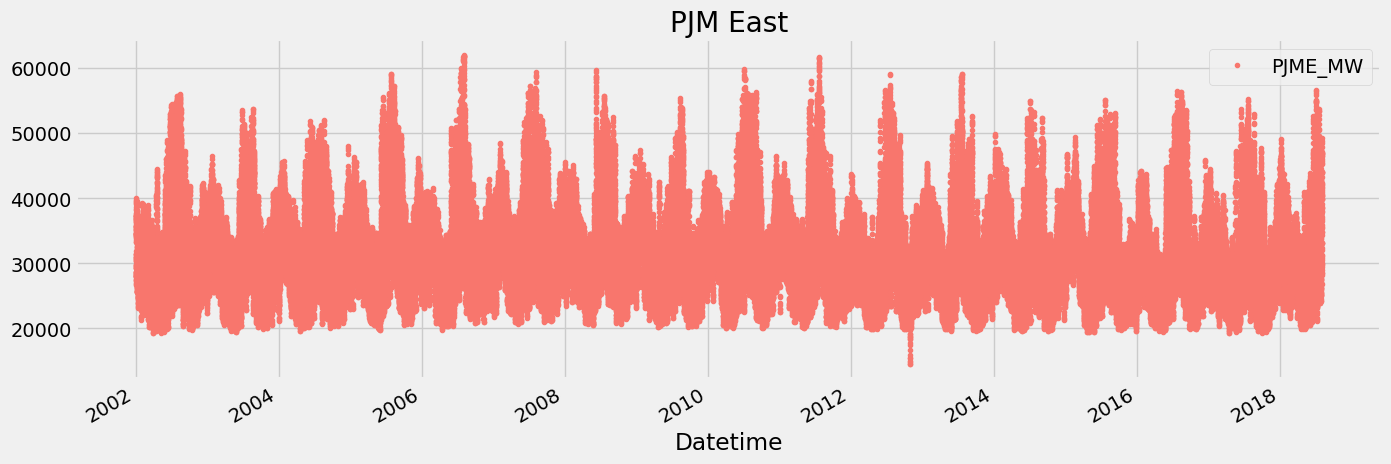

In [3]:
pjme = pd.read_csv(os.path.join(RAW_DATA_PATH, 'PJME_hourly.csv'), index_col=[0], parse_dates=[0])

color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

In [4]:
pjme.index.min(), pjme.index.max()

(Timestamp('2002-01-01 01:00:00'), Timestamp('2018-08-03 00:00:00'))

# Train/Test Split
Cut off the data after 2015 to use as our validation set.

In [5]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

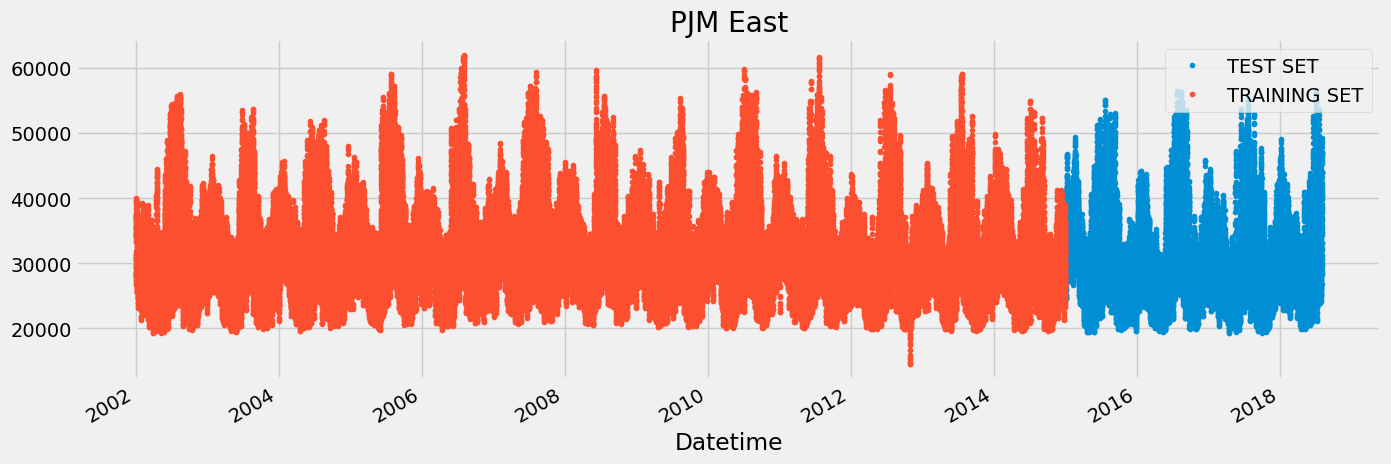

In [6]:
_ = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

# Create Time Series Features

In [7]:
# learn this way since it is more flexible for both data prepare and model training
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    # df['weekofyear'] = df['date'].dt.weekofyear
    df['weekofyear'] = df['date'].dt.isocalendar().week  # Updated line

    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [8]:
X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')

# Create XGBoost Model

In [10]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Feature Importances
Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

We can see that the day of year was most commonly used to split trees, while hour and year came in next. Quarter has low importance due to the fact that it could be created by different dayofyear splits.

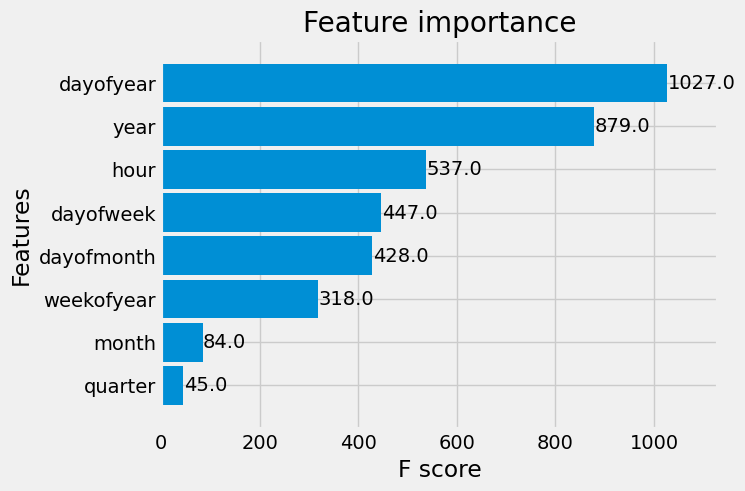

In [11]:
_ = plot_importance(reg, height=0.9)

# Forecast on Test Set

In [12]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

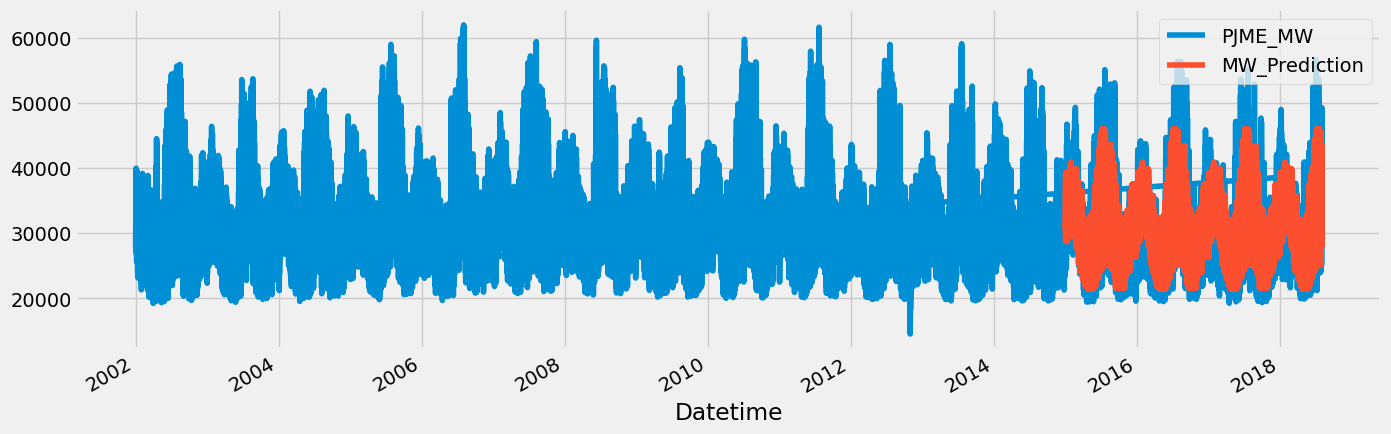

In [13]:
_ = pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

# Look at first month of predictions

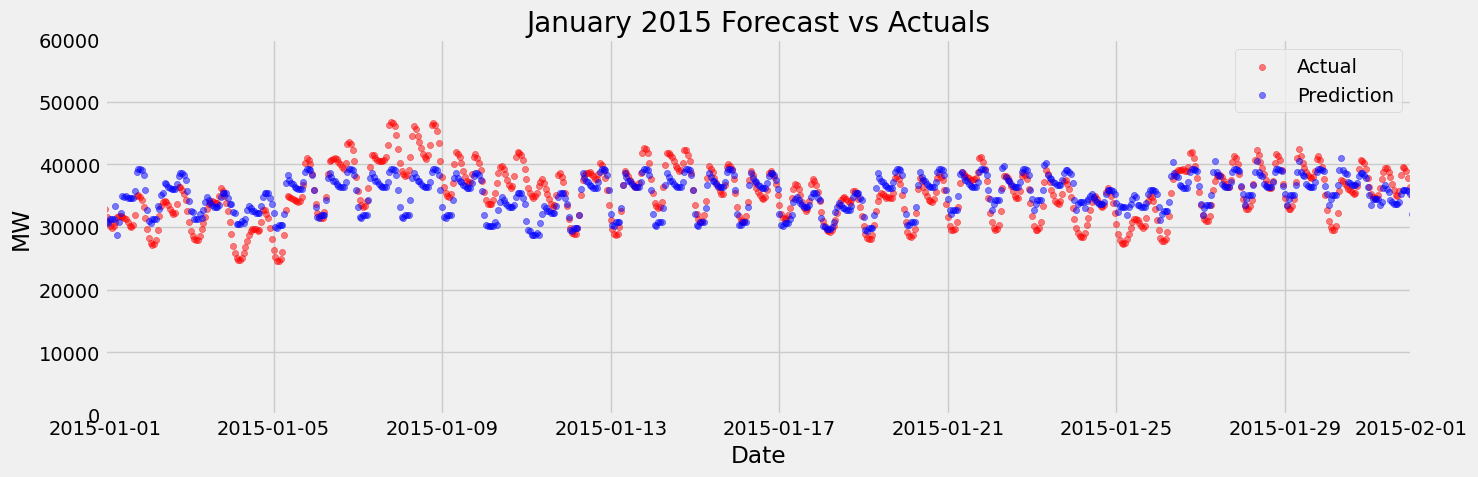

In [18]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1, figsize=(15, 5))

# Plot actual values
ax.scatter(pjme_all.index, pjme_all['PJME_MW'], 
           color='red', alpha=0.5, s=20, label='Actual')

# Plot predicted values
ax.scatter(pjme_all.index, pjme_all['MW_Prediction'], 
           color='blue', alpha=0.5, s=20, label='Prediction')

ax.set_xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2015-02-01'))
ax.set_ylim(0, 60000)
ax.set_xlabel('Date')
ax.set_ylabel('MW')
ax.legend()

plt.title('January 2015 Forecast vs Actuals')
plt.tight_layout()
plt.show()

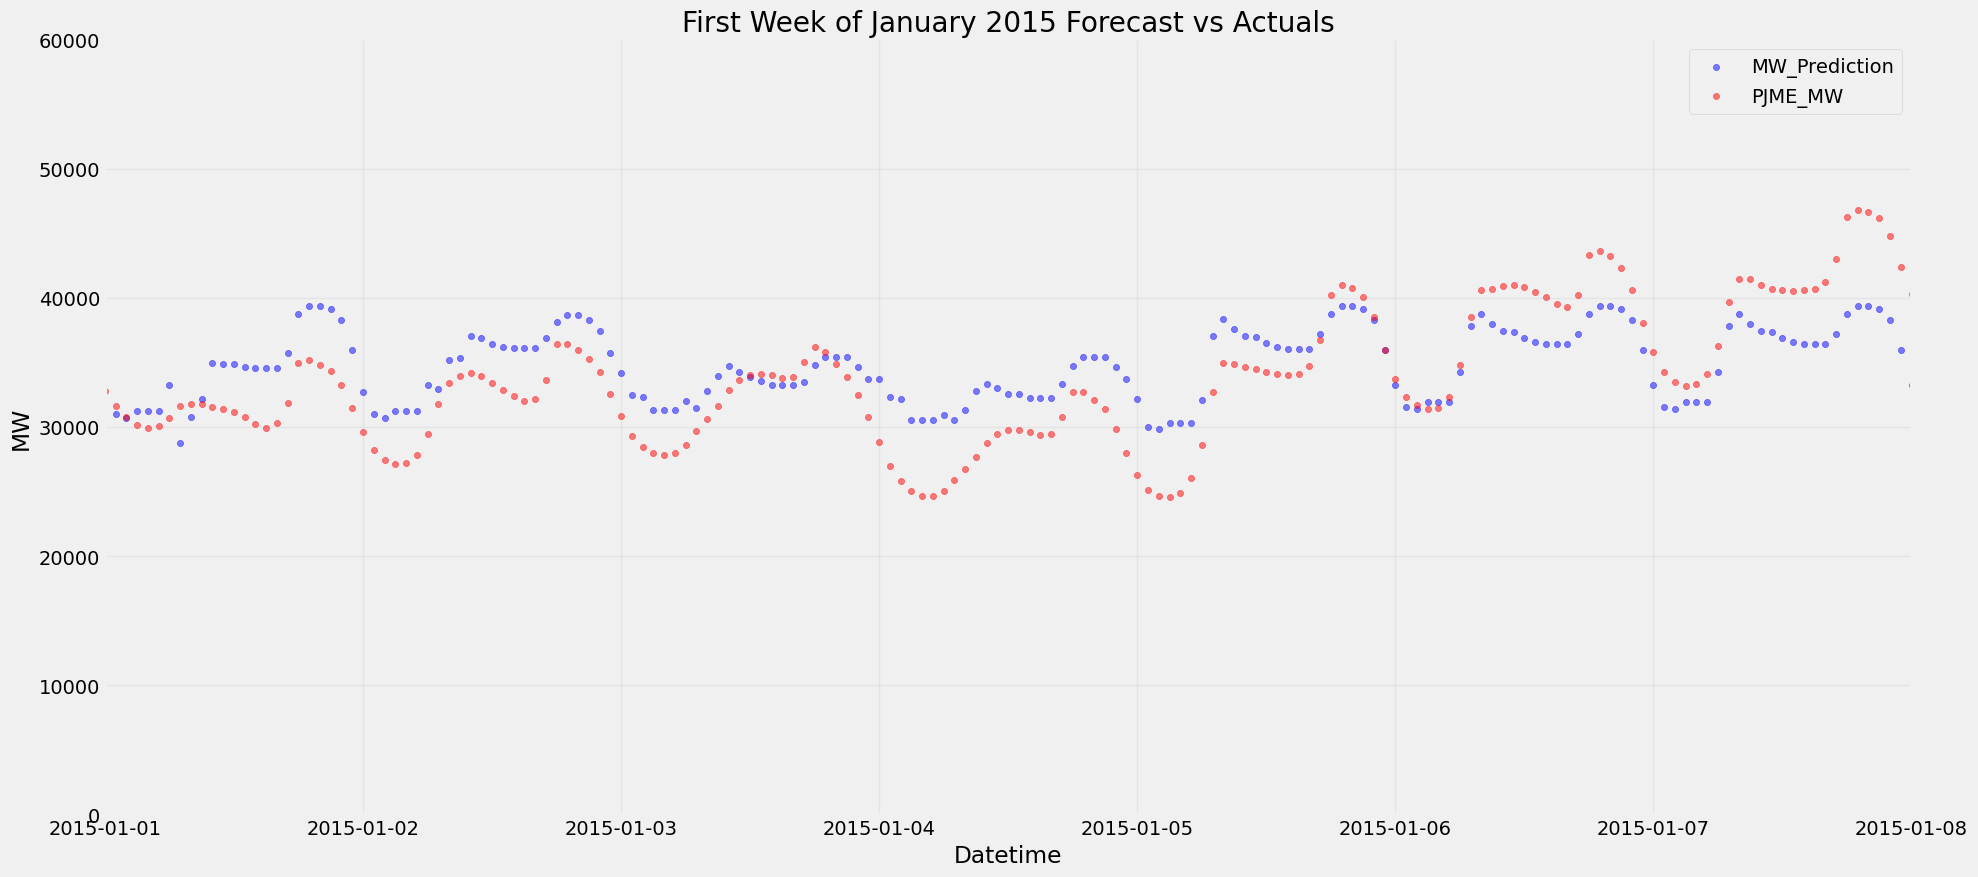

In [21]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1, figsize=(20, 9))

# Plot predicted values (blue dots)
ax.scatter(pjme_all.index, pjme_all['MW_Prediction'], 
           color='blue', alpha=0.5, s=20, label='MW_Prediction')

# Plot actual values (red dots)
ax.scatter(pjme_all.index, pjme_all['PJME_MW'], 
           color='red', alpha=0.5, s=20, label='PJME_MW')

ax.set_xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2015-01-08'))
ax.set_ylim(0, 60000)
ax.set_xlabel('Datetime')
ax.set_ylabel('MW')
ax.legend()

plt.title('First Week of January 2015 Forecast vs Actuals')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

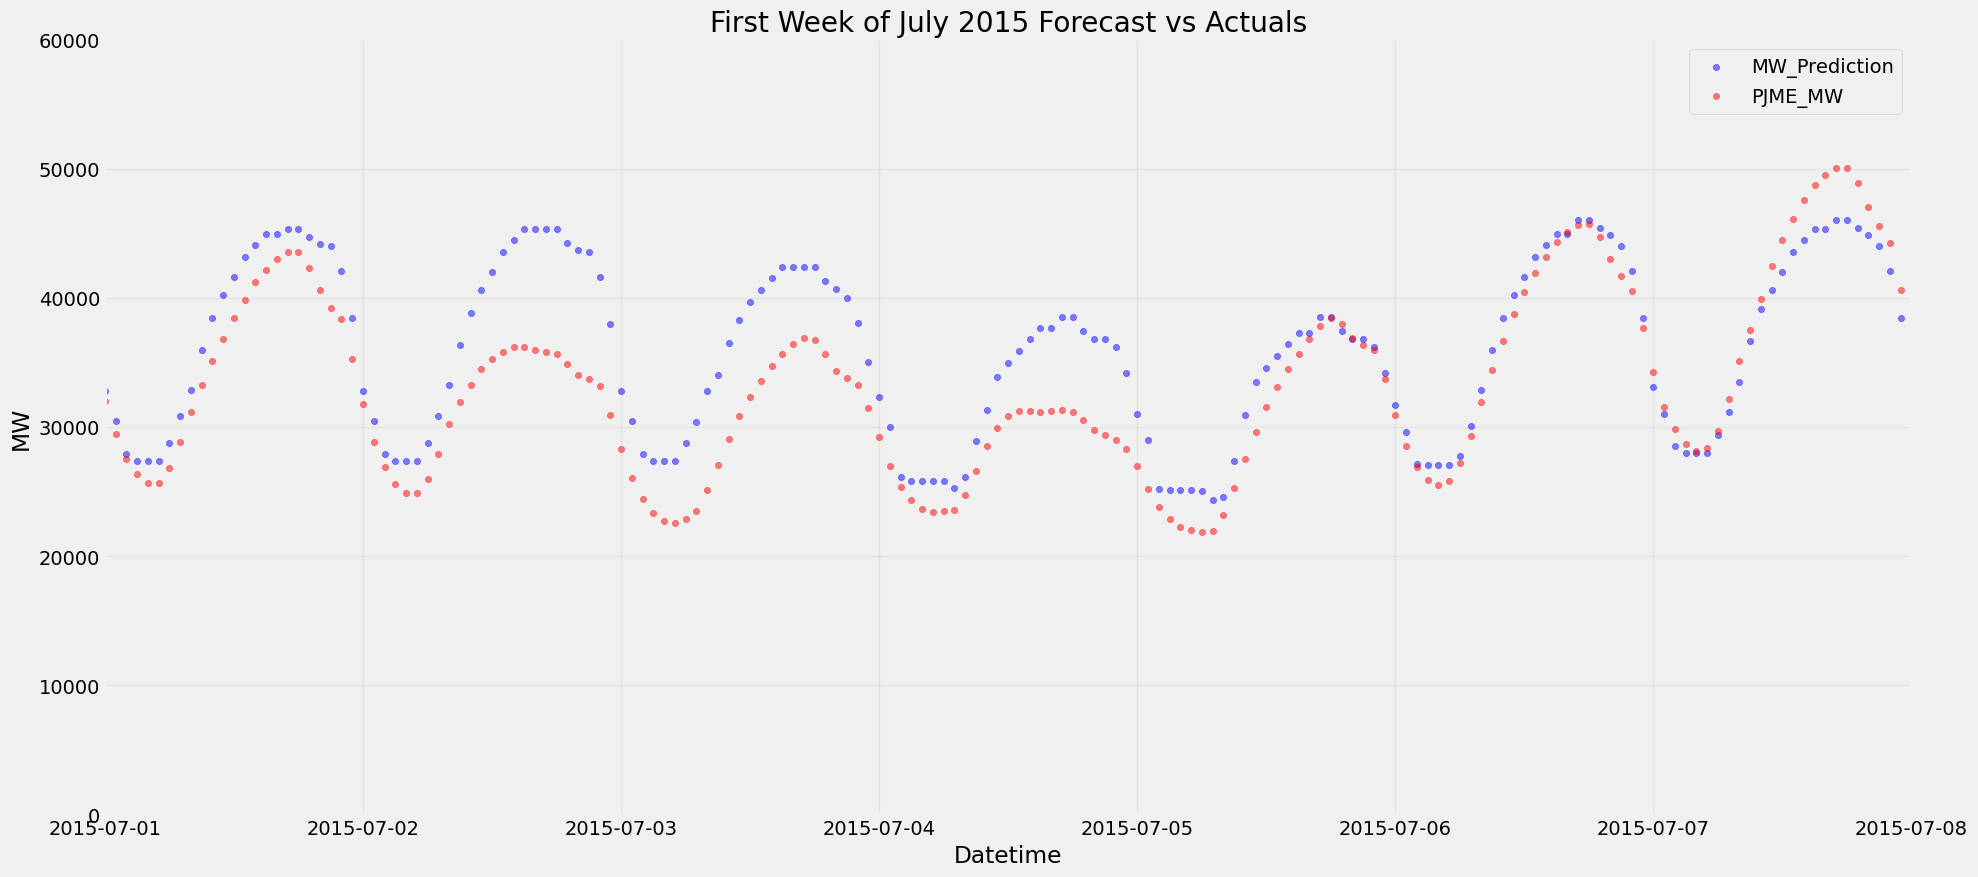

In [23]:
f, ax = plt.subplots(1,figsize=(20, 9))
# Plot predicted values (blue dots)
ax.scatter(pjme_all.index, pjme_all['MW_Prediction'], 
           color='blue', alpha=0.5, s=20, label='MW_Prediction')

# Plot actual values (red dots)
ax.scatter(pjme_all.index, pjme_all['PJME_MW'], 
           color='red', alpha=0.5, s=20, label='PJME_MW')

ax.set_xlim(pd.Timestamp('2015-07-01'), pd.Timestamp('2015-07-08'))
ax.set_ylim(0, 60000)
ax.set_xlabel('Datetime')
ax.set_ylabel('MW')
ax.legend()

plt.title('First Week of July 2015 Forecast vs Actuals')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Error Metrics On Test Set

In [26]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mse = mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])
mae = mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])
mape = mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])
# calculate RMSE
rmse = np.sqrt(mse)
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"RMSE: {rmse}")

MSE: 14055329.714256588
MAE: 2905.541158635075
MAPE: 9.239324261253785
RMSE: 3749.043840001953


# Look at Worst and Best Predicted Days

In [42]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week

    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

class XGBoostModel:
    def __init__(self, n_estimators=1000, early_stopping_rounds=50):
        self.model = xgb.XGBRegressor(n_estimators=n_estimators, early_stopping_rounds=early_stopping_rounds)
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None

    def prepare_data(self, df, split_date, target_column):
        df_train = df.loc[df.index <= split_date].copy()
        df_test = df.loc[df.index > split_date].copy()

        self.X_train, self.y_train = create_features(df_train, label=target_column)
        self.X_test, self.y_test = create_features(df_test, label=target_column)

    def train(self):
        self.model.fit(
            self.X_train, self.y_train,
            eval_set=[(self.X_train, self.y_train), (self.X_test, self.y_test)],
            verbose=False
        )

    def predict(self, X):
        return self.model.predict(X)

    def evaluate(self):
        y_pred = self.predict(self.X_test)
        mse = mean_squared_error(self.y_test, y_pred)
        mae = mean_absolute_error(self.y_test, y_pred)
        mape = mean_absolute_percentage_error(self.y_test, y_pred)
        rmse = np.sqrt(mse)

        return {
            'MSE': mse,
            'MAE': mae,
            'MAPE': mape,
            'RMSE': rmse
        }

def run_xgboost_model(df, split_date, target_column):
    model = XGBoostModel()
    model.prepare_data(df, split_date, target_column)
    model.train()
    metrics = model.evaluate()

    # Make predictions on the test set
    df_test = df.loc[df.index > split_date].copy()
    X_test = create_features(df_test)
    df_test['MW_Prediction'] = model.predict(X_test)

    return model, metrics, df_test

In [29]:
# calculate error and absolute error
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)

# This after calculating the error for each hour, then groups the data by day and calculates the mean error for each day.
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error']]

In [30]:
# Over forecasted days
# the top 10 days where the model most significantly over-predicted the energy consumption, averaged across each day.
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2016 7     4           28399.958333   37517.796875 -9117.839681  9117.839681
2017 2     24          26445.083333   34674.246094 -8229.161458  8229.161458
           25          24344.458333   32168.185547 -7823.726562  7823.726562
           20          27070.583333   34739.832031 -7669.247314  7669.247314
           23          27663.416667   35189.988281 -7526.572591  7526.572591
           19          24555.500000   32075.916016 -7520.415690  7520.415690
2018 2     21          27572.500000   35071.636719 -7499.138509  7499.138509
2017 2     28          28297.875000   35777.996094 -7480.123128  7480.123128
2015 12    25          24466.083333   31934.242188 -7468.158447  7468.158447
2017 5     29          24528.416667   31898.537109 -7370.119873  7370.119873

Notice anything about the over forecasted days? 
- #1 worst day - July 4th, 2016 - is a holiday. 
- #3 worst day - December 25, 2015 - Christmas
- #5 worst day - July 4th, 2016 - is a holiday.   
Looks like our model may benefit from adding a holiday indicator.

In [31]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJME_MW  MW_Prediction         error     abs_error
year month dayofmonth                                                         
2016 8     13          45185.833333   31933.914062  13251.918294  13251.918294
           14          44427.333333   31571.750000  12855.583659  12855.583659
     9     10          40996.166667   29232.009766  11764.157145  11764.157145
           9           43836.958333   32909.222656  10927.734863  10927.734863
2018 1     6           43565.750000   33295.785156  10269.967285  10269.967285
2016 8     12          45724.708333   35532.207031  10192.502441  10192.502441
2015 2     20          44694.041667   34555.894531  10138.147624  10138.147624
2018 1     7           42159.708333   32626.416016   9533.292318   9533.292318
2017 5     19          38032.583333   28695.617188   9336.965169   9336.965169
2015 2     16          43949.500000   34774.941406   9174.557210   9174.557210

The best predicted days seem to be a lot of october (not many holidays and mild weather) Also early may

In [32]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2016 12    30          32213.458333   32181.333984   32.125244  293.829183
     10    27          28611.166667   28468.591797  142.576579  395.899007
2017 10    24          28657.416667   28500.578125  156.839274  418.409749
2015 10    28          28500.958333   28500.578125    0.380941  437.252360
     5     6           28948.666667   28924.179688   24.486898  467.199788
2016 8     8           36256.041667   36075.062500  180.978190  565.314616
2017 9     14          32033.875000   31962.031250   71.842448  596.341634
     5     2           28546.916667   28924.179688 -377.263102  596.743408
     8     12          31822.666667   32056.876953 -234.211263  597.051595
2016 12    12          32757.208333   33159.648438 -402.439290  597.560872

# Plotting some best/worst predicted days

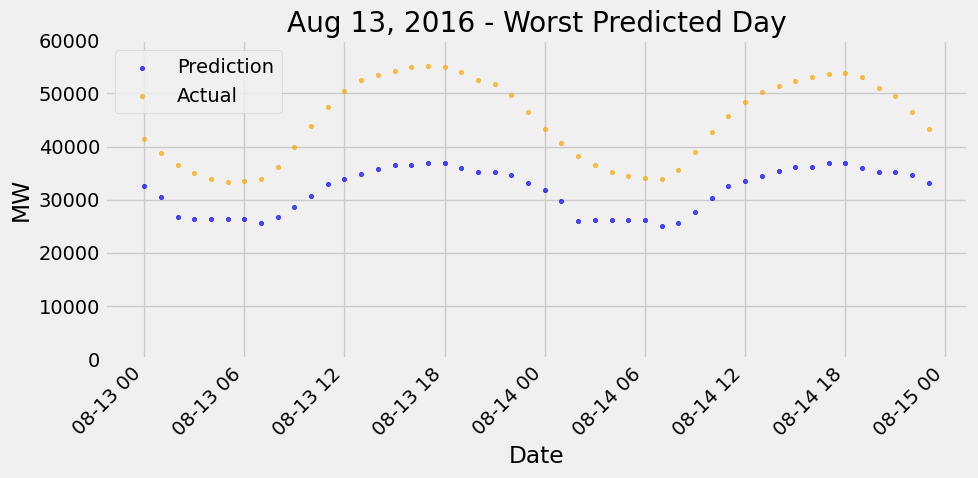

In [36]:
# First, sort the index
pjme_all_sorted = pjme_all.sort_index()

# Now create the plot
f, ax = plt.subplots(1, figsize=(10, 5))

# Plot predicted values
ax.scatter(pjme_all_sorted.loc['2016-08-13':'2016-08-14'].index, 
           pjme_all_sorted.loc['2016-08-13':'2016-08-14']['MW_Prediction'],
           color='blue', s=10, alpha=0.7, label='Prediction')

# Plot actual values
ax.scatter(pjme_all_sorted.loc['2016-08-13':'2016-08-14'].index, 
           pjme_all_sorted.loc['2016-08-13':'2016-08-14']['PJME_MW'],
           color='orange', s=10, alpha=0.7, label='Actual')

ax.set_ylim(0, 60000)
ax.set_xlabel('Date')
ax.set_ylabel('MW')
ax.legend()

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()  # Rotation
plt.xticks(rotation=45, ha='right')  # Rotate by 45 degrees and align

plt.title('Aug 13, 2016 - Worst Predicted Day')
plt.tight_layout()
plt.show()

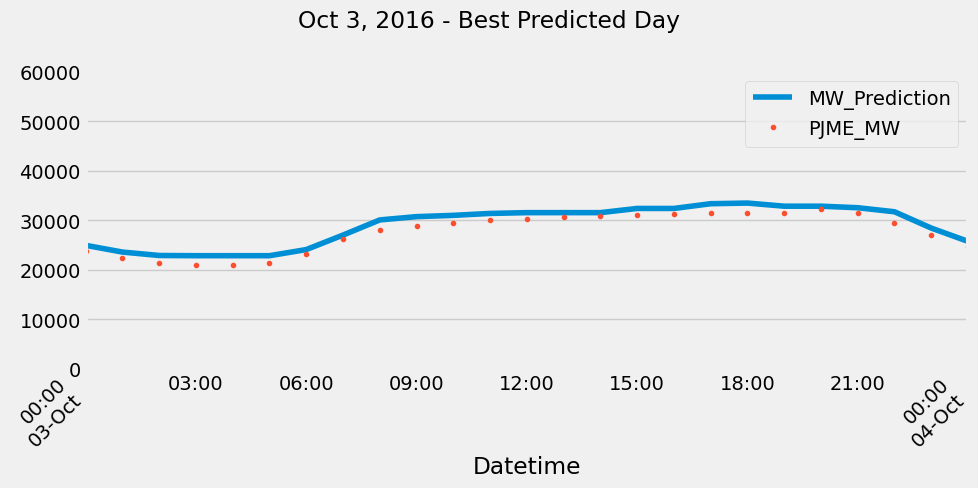

In [41]:
# Sort the index to ensure it's monotonic
# good match
pjme_all_sorted = pjme_all.sort_index()

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)

# Create a boolean mask for the date range
mask = (pjme_all_sorted.index >= '2016-10-03') & (pjme_all_sorted.index < '2016-10-05')

# Plot the data
_ = pjme_all_sorted.loc[mask][['MW_Prediction', 'PJME_MW']].plot(ax=ax, style=['-', '.'])

ax.set_ylim(0, 60000)
ax.set_xlim(pd.Timestamp('2016-10-03'), pd.Timestamp('2016-10-04'))

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()  # Rotation
plt.xticks(rotation=45, ha='right')  # Rotate by 45 degrees and align

plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')
plt.tight_layout()
plt.show()

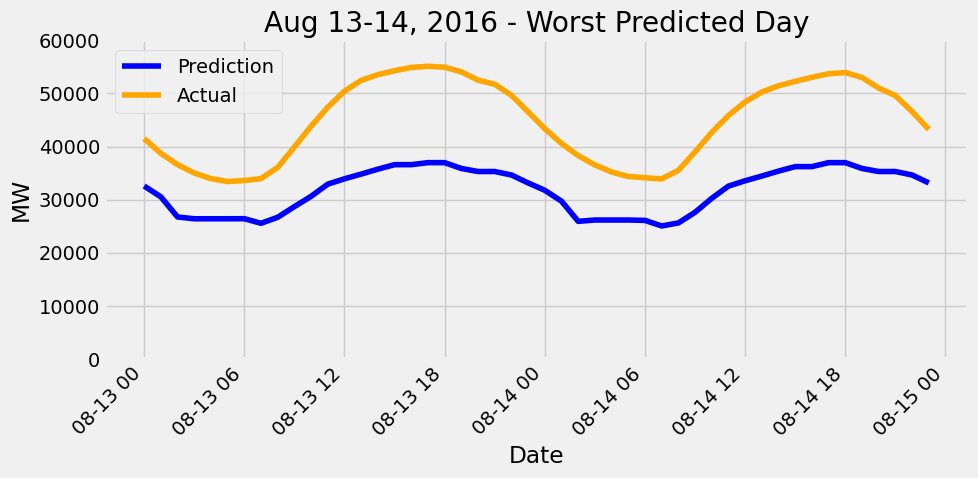

In [40]:
# Sort the index to ensure it's monotonic
pjme_all_sorted = pjme_all.sort_index()

# Create a boolean mask for the date range
mask = (pjme_all_sorted.index >= '2016-08-13') & (pjme_all_sorted.index < '2016-08-15')

f, ax = plt.subplots(1, figsize=(10, 5))

# Plot predicted values
ax.plot(pjme_all_sorted.loc[mask].index, 
        pjme_all_sorted.loc[mask]['MW_Prediction'],
        color='blue', label='Prediction')

# Plot actual values
ax.plot(pjme_all_sorted.loc[mask].index, 
        pjme_all_sorted.loc[mask]['PJME_MW'],
        color='orange', label='Actual')

ax.set_ylim(0, 60000)
ax.set_xlabel('Date')
ax.set_ylabel('MW')
ax.legend()

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()  # Rotation
plt.xticks(rotation=45, ha='right')  # Rotate by 45 degrees and align

plt.title('Aug 13-14, 2016 - Worst Predicted Day')
plt.tight_layout()
plt.show()

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

# Up next?
- Add Lag variables
- Add holiday indicators.
- Add weather data source.